In [6]:
# Install necessary libraries (if not already installed)
!pip install scikit-learn pandas numpy


In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


In [7]:
df=pd.read_csv('laptops.csv')

df.head()

,Unnamed: 0,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,0,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo Intel Core i5 11th Gen,62990,Intel Core i5 Processor (11th Gen),16 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.5,14.0,1.0
1,1,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo V15 G2 Core i3 11th Gen,37500,Intel Core i3 Processor (11th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,1 TB HDD|256 GB SSD,15.6,4.4,53.0,3.0
2,2,https://rukminim1.flixcart.com/image/312/312/l...,ASUS TUF Gaming F15 Core i5 10th Gen,49990,Intel Core i5 Processor (10th Gen),8 GB DDR4 RAM,Windows 11 Operating System,512 GB SSD,15.6,4.4,4733.0,463.0
3,3,https://rukminim1.flixcart.com/image/312/312/x...,ASUS VivoBook 15 (2022) Core i3 10th Gen,33990,Intel Core i3 Processor (10th Gen),8 GB DDR4 RAM,64 bit Windows 11 Operating System,512 GB SSD,15.6,4.3,10406.0,1040.0
4,4,https://rukminim1.flixcart.com/image/312/312/x...,Lenovo Athlon Dual Core,18990,AMD Athlon Dual Core Processor,4 GB DDR4 RAM,DOS Operating System,256 GB SSD,14.0,3.8,18.0,3.0


In [13]:

# Handle missing values only for numeric columns
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)




In [21]:
print(df.columns)

if 'user_id' not in df.columns or 'rating' not in df.columns:
    df['user_id'] = np.random.randint(1, 101, size=len(df))  # 100 users
    df['rating'] = np.random.randint(1, 6, size=len(df))  # Ratings from 1 to 5

# Assign unique IDs to laptops
df['laptop_id'] = range(1, len(df) + 1)

user_laptop_matrix = df.pivot_table(index='user_id', columns='laptop_id', values='rating', fill_value=0)









Index(['Unnamed: 0', 'img_link', 'name', 'price(in Rs.)', 'processor', 'ram',
       'os', 'storage', 'display(in inch)', 'rating', 'no_of_ratings',
       'no_of_reviews', 'laptop_id', 'user_id'],
      dtype='object')


In [22]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20)
matrix_svd = svd.fit_transform(user_laptop_matrix)

print(matrix_svd.shape)  # Should be (num_users, 20)
user_index = 0  # Example user
scores = matrix_svd[user_index] @ svd.components_
recommended_laptops = scores.argsort()[::-1]  # Sorted recommendations



(100, 20)


In [23]:
def recommend_laptops(user_id, num_recommendations=5):
    user_idx = user_id - 1  # Adjust index
    user_ratings = np.dot(matrix_svd[user_idx], svd.components_)  # Predict ratings
    laptop_scores = list(enumerate(user_ratings))  # Pair (laptop_id, score)
    laptop_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by score

    print(f"\n🔹 **Top {num_recommendations} Recommended Laptops for User {user_id}:**")
    for i, (laptop_id, score) in enumerate(laptop_scores[:num_recommendations]):
        laptop_name = df.loc[df['laptop_id'] == laptop_id, 'name'].values[0]
        print(f"{i+1}. {laptop_name} (Predicted Rating: {round(score, 2)})")

# Test with a sample user
recommend_laptops(user_id=5)



🔹 **Top 5 Recommended Laptops for User 5:**
1. MSI Alpha 15 Ryzen 7 Octa Core 5800H (Predicted Rating: 4.95)
2. DELL Vostro Ryzen 3 Quad Core 5425U (Predicted Rating: 4.95)
3. DELL Vostro Core i3 11th Gen (Predicted Rating: 4.95)
4. HP Ryzen 5 Hexa Core 5500U (Predicted Rating: 4.95)
5. Lenovo IdeaPad 3 Core i5 11th Gen (Predicted Rating: 3.96)


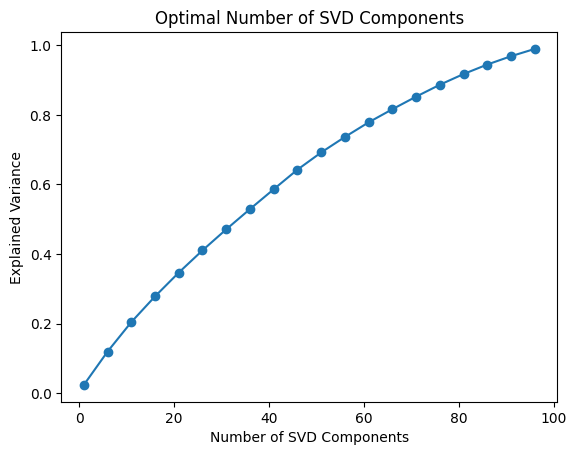

In [25]:
import matplotlib.pyplot as plt

user_laptop_matrix = df.pivot_table(index='user_id', columns='laptop_id', values='rating').fillna(0)

# Find optimal SVD components
explained_variance = []
components = range(1, min(user_laptop_matrix.shape) + 1, 5)  # Test in steps of 5

for n in components:
    svd = TruncatedSVD(n_components=n)
    svd.fit(user_laptop_matrix)
    explained_variance.append(sum(svd.explained_variance_ratio_))

# Plot variance vs. components
plt.plot(components, explained_variance, marker='o')
plt.xlabel("Number of SVD Components")
plt.ylabel("Explained Variance")
plt.title("Optimal Number of SVD Components")
plt.show()

In [26]:
optimal_components = 30
svd = TruncatedSVD(n_components=optimal_components)
matrix_svd = svd.fit_transform(user_laptop_matrix)


In [27]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(matrix_svd)

# Convert to a DataFrame for easy lookup
user_sim_df = pd.DataFrame(user_similarity, index=user_laptop_matrix.index, columns=user_laptop_matrix.index)

def recommend_laptops(user_id, num_recommendations=5):
    # Find most similar user
    similar_users = user_sim_df[user_id].sort_values(ascending=False).index[1:6]  # Exclude self

    # Aggregate laptop ratings from similar users
    similar_users_ratings = user_laptop_matrix.loc[similar_users].mean()

    # Recommend laptops the user hasn't rated
    user_rated = user_laptop_matrix.loc[user_id]
    recommendations = similar_users_ratings[user_rated == 0].sort_values(ascending=False).head(num_recommendations)

    print(f"\n🔹 **Top {num_recommendations} Laptop Recommendations for User {user_id}:**")
    for i, (laptop_id, score) in enumerate(recommendations.items()):
        laptop_name = df.loc[df['laptop_id'] == laptop_id, 'name'].values[0]
        print(f"{i+1}. {laptop_name} (Predicted Rating: {round(score, 2)})")

# Test with a sample user
recommend_laptops(user_id=5)



🔹 **Top 5 Laptop Recommendations for User 5:**
1. acer Extensa Core i3 11th Gen (Predicted Rating: 1.0)
2. Lenovo IdeaPad 3 Core i3 11th Gen (Predicted Rating: 1.0)
3. HP Core i3 11th Gen (Predicted Rating: 1.0)
4. Lenovo Intel Core i5 11th Gen (Predicted Rating: 1.0)
5. HP Victus Core i7 12th Gen (Predicted Rating: 1.0)
